# **Real Estate Price Prediction**

This project aims to build a predictive model for real estate prices using machine learning techniques in PySpark. The model predicts house prices per unit area based on various features like the number of convenience stores, latitude, and longitude. The process includes data preparation, feature engineering, model training, evaluation, and visualization.

***Analyze the correlation of each column in our dataset with house_price_per_unit_area to understand how each feature relates to the target variable***

In [1]:
import pandas as pd

# Assuming you have loaded the data into a DataFrame called df
df = pd.read_csv('Real estate.csv')

# Calculate correlation matrix
correlation_matrix = df.corr()

# Get correlation with 'house_price_per_unit_area'
price_corr = correlation_matrix['house_price_per_unit_area'].sort_values(ascending=False)

print(price_corr)

house_price_per_unit_area       1.000000
number_of_convenience_stores    0.571005
latitude                        0.546307
longitude                       0.523287
transaction_date                0.087491
No                             -0.028587
house_age                      -0.210567
nearest_MRT_station_distance   -0.673613
Name: house_price_per_unit_area, dtype: float64


***Install necessary libraries***

In [ ]:
%pip install pyspark
%pip install findspark
%pip install pandas
%pip install matplotlib

*You can also use this section to suppress warnings generated by your code:*

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

***Initialize FindSpark***

In [4]:
import findspark
findspark.init()

***Import necessary modules***

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator

***Create SparkSession***

In [ ]:
spark = SparkSession.builder.appName("Real Estate Price Prediction").getOrCreate()

***Load CSV file into Spark DataFrame***

In [7]:
data = spark.read.csv("Real estate.csv", header=True, inferSchema=True)

### **Data Cleaning**

*Remove duplicates, drop null values, and rename columns for consistency and clarity.*

In [8]:
data = data.dropDuplicates()
data = data.dropna()
data = data.filter(data["house_age"] > 0)

data.printSchema()
data.show(5)

root
 |-- No: integer (nullable = true)
 |-- transaction_date: double (nullable = true)
 |-- house_age: double (nullable = true)
 |-- nearest_MRT_station_distance: double (nullable = true)
 |-- number_of_convenience_stores: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- house_price_per_unit_area: double (nullable = true)



+---+----------------+---------+----------------------------+----------------------------+--------+---------+-------------------------+
| No|transaction_date|house_age|nearest_MRT_station_distance|number_of_convenience_stores|latitude|longitude|house_price_per_unit_area|
+---+----------------+---------+----------------------------+----------------------------+--------+---------+-------------------------+
|222|        2013.333|      9.0|                    1402.016|                           0|24.98569| 121.5276|                     38.5|
|282|        2013.333|      4.7|                    387.7721|                           9|24.98118|121.53788|                     44.8|
| 37|        2012.917|     14.7|                    1935.009|                           2|24.96386|121.51458|                     22.9|
| 52|        2013.083|     31.3|                    1758.406|                           1|24.95402|121.55282|                     20.7|
|297|         2012.75|     12.5|                

***Convert DataFrame to Parquet File***

In [9]:
data.write.mode("overwrite").parquet("real_estate.parquet")
data = spark.read.parquet("real_estate.parquet")

## **Data Pipeline Stage**

*Stage 1 - assemble input columns into a single vector*

In [10]:
vectorAssembler = VectorAssembler(inputCols=["number_of_convenience_stores","latitude","longitude"], outputCol = "features")

*Stage 2 - scale the features using standard scaler*

In [11]:
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures")

*Stage 3 - create RandomForestRegressor instance*

In [12]:
rf = RandomForestRegressor(featuresCol = "scaledFeatures", labelCol = "house_price_per_unit_area")

## **Build Pipeline**

*All the stages of the pipeline are mentioned in the order of execution*

In [13]:
pipeline = Pipeline(stages = [vectorAssembler, scaler, rf])

*Split the data into training and testing sets*

In [14]:
(trainingData, testData) = data.randomSplit([0.7, 0.3], seed = 42)

*Fit the pipeline to training data*

In [15]:
pipelineModel = pipeline.fit(trainingData)

*Make predictions on testing data*

In [16]:
predictions = pipelineModel.transform(testData)

## **Evaluation Metrics**

Assess model performance using evaluation metrics such as R² (coefficient of determination), RMSE (Root Mean Squared Error), and MAE (Mean Absolute Error) to gauge accuracy and predictive power.

$R^2$

In [17]:
evaluator = RegressionEvaluator(labelCol="house_price_per_unit_area", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R Squared =", r2)

R Squared = 0.6945278655280449


*Root Mean Squared Error (RMSE)*

In [18]:
evaluator = RegressionEvaluator(labelCol="house_price_per_unit_area", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE =", rmse)

RMSE = 6.798541331469675


*Mean Absolute Error (MAE)*

In [19]:
evaluator = RegressionEvaluator(labelCol="house_price_per_unit_area", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE =", mae)

MAE = 5.338563319921134


## **Persist the Model**

In [20]:
pipelineModel.write().overwrite().save("House Prediction Model")

*Loading the saved model*

In [21]:
loadedPipelineModel = PipelineModel.load("House Prediction Model")

/Users/razel/Python Projects/.venv/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py:154: DeprecationWarning: This process (pid=2760) is multi-threaded, use of fork() may lead to deadlocks in the child.


*Make predictions using testing data*

In [22]:
predictions = loadedPipelineModel.transform(testData)
predictions.select("house_price_per_unit_area", "prediction").show(5)

+-------------------------+------------------+
|house_price_per_unit_area|        prediction|
+-------------------------+------------------+
|                     47.3| 48.34410636120027|
|                     40.3| 44.42321052264481|
|                     18.8| 17.58343097041847|
|                     22.1|26.726846508746007|
|                     23.8| 24.37354372294373|
+-------------------------+------------------+
only showing top 5 rows



## **Visualization**

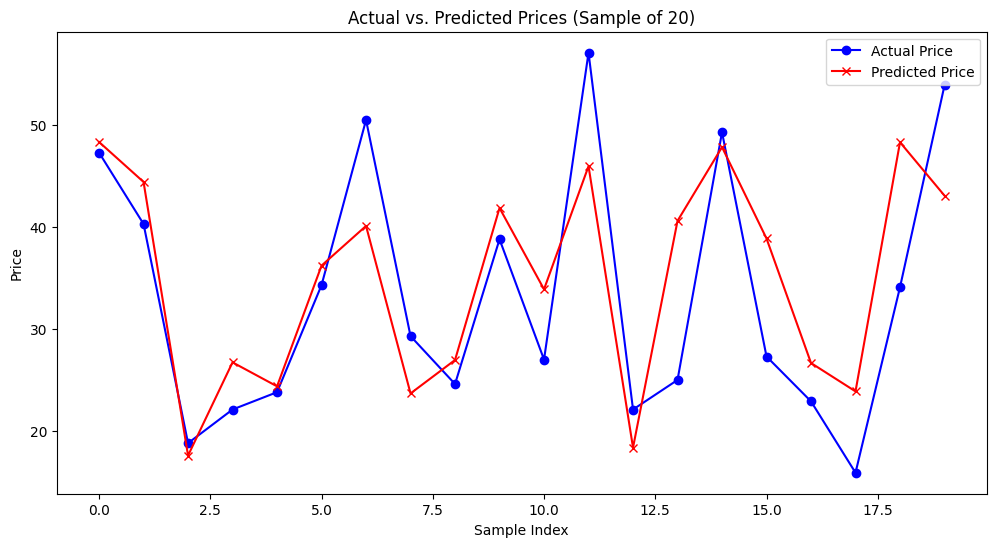

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample 20 rows from the predictions DataFrame
sample_data = predictions.select("house_price_per_unit_area", "prediction").toPandas().head(20)

# Extract data for plotting
actual_prices = sample_data["house_price_per_unit_area"]
predicted_prices = sample_data["prediction"]

# Plotting
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(actual_prices.index, actual_prices, label='Actual Price', color='blue', linestyle='-', marker='o')

# Plot predicted prices
plt.plot(predicted_prices.index, predicted_prices, label='Predicted Price', color='red', linestyle='-', marker='x')

# Add titles and labels
plt.title('Actual vs. Predicted Prices (Sample of 20)')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.show()


*Finally, stop the Spark session*

In [ ]:
spark.stop()